In [17]:
import math
import numpy as np
import pandas as pd
import pints
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 24})
from Newton_model_numba import wrappedNewton, newtonRaphsonFT
from one_step_model_numba import wrappedOneStepModel, oneStepModel

In [18]:
class ComplexRootMeanSquaredError_harmonics(pints.ProblemErrorMeasure):
    def __init__(self, problem, model, Hz_interval, times, adjustment = -1, fourthAdjustment = -4):
        super(ComplexRootMeanSquaredError_harmonics, self).__init__(problem)

        if not isinstance(problem, pints.SingleOutputProblem):
            raise ValueError(
                'This measure is only defined for single output problems.')
        
        self.FT_values = model.FT_and_reduce_to_harmonics_4_to_12(self._values)
        self.harmonic_spacing = model.harmonic_spacing(self._values, times, adjustment = adjustment)
        print('harmonic_spacing (480): ', self.harmonic_spacing)
        self.freq = model.frequencies_for_harmonics_4_to_12(times =times)
        x = np.where(self.freq < model.freq*4)
        self.mid_point_index = x[0][-1] + fourthAdjustment
        print('mid_point_index (89): ', self.mid_point_index)
        self.index_window = int(np.round(model.index_distance_covering(Hz_interval, times)))
        print('index_window (32): ', self.index_window)
        self.data_dims = self.FT_values.shape[0]

        # np.absolute takes the element wise absoulte value of real numbers, 
        # and the element-wise modules/eulcdiean norm/ absoulte value of comlex numbers
        # i.e for: z = a +bi
        # |z| = sqrt(a^2+b^2)

    def __call__(self, x):

        simulation = self._problem.evaluate(x)
        reduced_FT_sim = model.FT_and_reduce_to_harmonics_4_to_12(simulation)

        low = int(self.mid_point_index - self.index_window)
        mid = int(self.mid_point_index)
        high = int(self.mid_point_index+ self.index_window + 1)

        total_complex_diff = 0.0
        harmonic = 4   
        while high <= self.data_dims:
            sim_harmonic = reduced_FT_sim[low:high]
            exp_harmonic = self.FT_values[low:high]

            # plt.figure(figsize=(18,10))
            # plt.title("simulation FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq, np.log10(self.FT_values),'k', label='experimental harm 4 -12')
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("simulated on experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq, np.log10(self.FT_values),'k', label='experimental harm 4 -12')
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("simulated on experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'kX', label='harmonic_center')
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            kaiser_window = np.kaiser(exp_harmonic.shape[0], 0)

            complex_diff = sim_harmonic - exp_harmonic

            windowed = np.multiply(kaiser_window,complex_diff)

            total_complex_diff = total_complex_diff + windowed

            # increasing indexing
            high = high + self.harmonic_spacing
            mid = mid + self.harmonic_spacing
            low = low + self.harmonic_spacing

            harmonic = harmonic + 1

        # complex_diff = reduced_FT_sim - self.FT_values

        # magnatuide = np.absolute(complex_diff)

        magnatuide = np.absolute(total_complex_diff)

        squares = np.square(magnatuide)

        sumed = np.sum(squares)

        return np.sqrt(sumed)

In [19]:
# # specifing files and model 
# # specifing data location and folder for outputs

# Phfolder = ['ph4 2m nacl 25oC','ph5 2m nacl 25oC','ph6 2m nacl 25oC','ph7 2m nacl 25oC','ph8 2m nacl 25oC','ph9 2m nacl 25oC']

# data_file_names = ['9_1b_cv_current_reduced_0', '9 150_1_cv_current_reduced_0',
#                     '9 150_1_cv_current_reduced_0', '9 150_1_cv_current_reduced_0',
#                     '9 150_1_cv_current_reduced_0', '9 150_1_cv_current_reduced_0']

# experiment_folder = ['9_1b', '9 150_1',
#                      '9 150_1', '9 150_1',
#                      '9 150_1', '9 150_1']


# startPotential_list = [-50.0E-3, -100.0E-3, -150.0E-3, -200.0E-3, -250.0E-3, -300.0E-3]
# revPotential_list = [-650.0E-3, -700.0E-3, -750.0E-3, -800.0E-3, -850.0E-3, -900.0E-3]
# uncomp_resis_list = [3.25459258134767921e+01, 5.37315648829909520e+01, 7.08611444464832800e+01, 9.96182105930900406e+01, 1.21158504446797167e+02, 8.49461271867468355e+01]

# cap_params_list = [[1.86297231895378234e-04,  1.39822668111257240e-04,  3.70334763842398995e-04,  1.95151458630165057e-04,
#                     1.89160175800536629e-04,  1.72641582414570635e-04,  4.39360685286188006e-04,  2.43245044482993467e-04,
#                     -6.47033620007000394e+01],

#                     [1.94632384807037420e-04,  1.09253279202811606e-04,  2.88119296913558502e-04,  1.26365659832472976e-04,
#                     2.02905524533143831e-04,  1.80802994708567557e-04,  4.31389682179686342e-04,  2.20819252636918900e-04,
#                     -6.47033294616361019e+01],

#                     [2.04723750338681946e-04,  2.31336124514676302e-05,  6.72508062131533472e-05, -3.52789052587041763e-05,
#                     2.19537063820266680e-04,  1.36486944707261103e-04,  2.84492337211128500e-04,  9.96760436029462717e-05,
#                     -6.47033565846734575e+01],

#                     [2.31095670596632297e-04, -3.33935918269465505e-05,  2.61213767197990623e-05, -4.37105855050501238e-05,
#                     2.48585910357163357e-04,  8.43384306423355847e-05,  2.31490537079119671e-04,  7.27245330412529863e-05,
#                     -6.47034052381796130e+01],

#                     [2.10391107458934992e-04, -1.67952604491567012e-04, -2.27521114816858663e-04, -1.82193875674134206e-04,
#                     2.37152182054913105e-04, -1.71348627672825594e-05,  1.08690359778462926e-05, -5.80862929614741437e-05,
#                     -6.47034055661957552e+01],
                    
#                     [1.66897412567862006e-04, -3.31979915125576596e-04, -5.19143040976281084e-04, -3.20477836314988726e-04,
#                     2.13029444583132078e-04, -9.50966568724915390e-05, -1.66949344271613391e-04, -1.49813542866588539e-04,
#                     -6.47034179321291987e+01]
#                     ]

# # know paramteres for 9 150_1_cv_current_reduced_2
# freq = 8.977950e+00
# rateOfPotentialChange = -22.35174e-3

# deltaepislon = 150.0E-3
# electrode_area = 0.03
# electode_coverage = 6.5e-12


# Hz_interval_fitting_interval = 0.8

experimental data:  Data/processed/220415/ph4 2m nacl 25oC/ac/9_1b/experimental/9_1b_cv_current_reduced_0.txt
x[0][-1]:  482
y[0][0]:  483
z[0]:  []


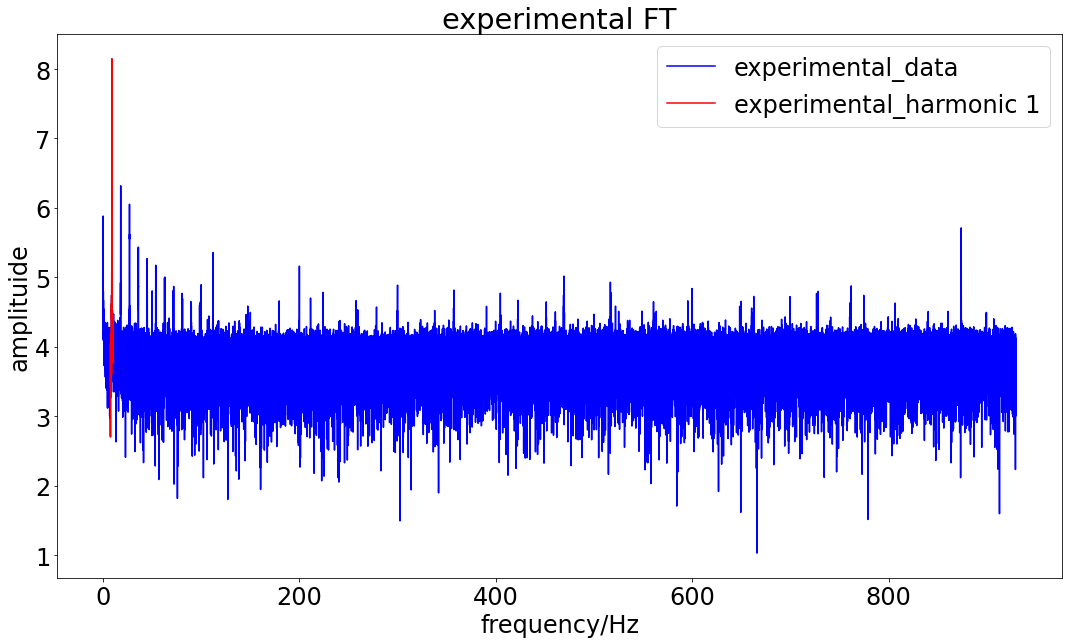

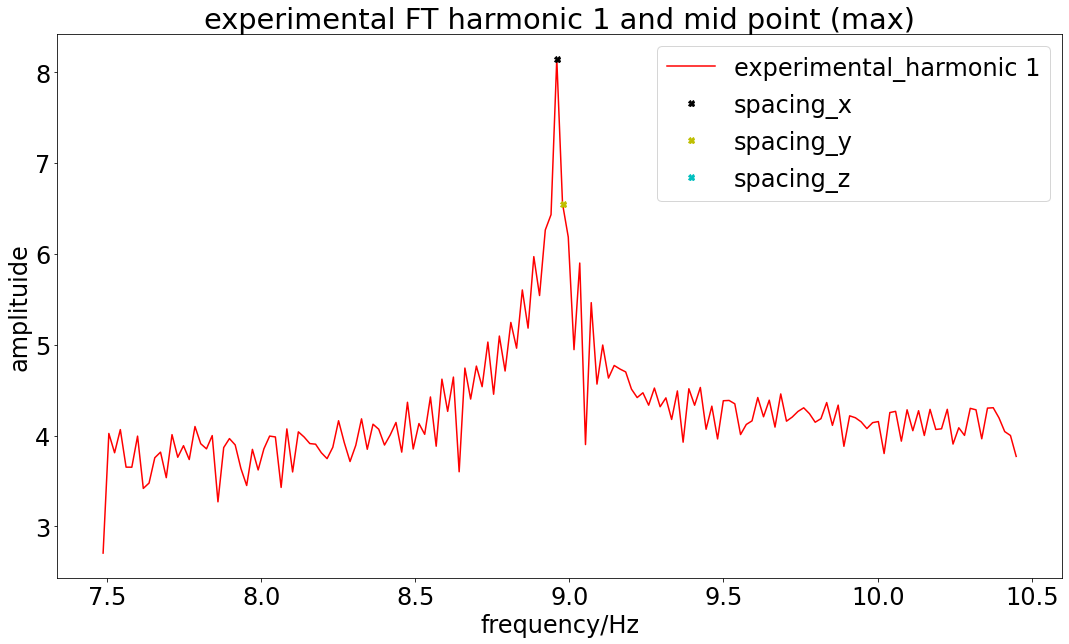

87640.1   6:42.2
560   5049   387640.1   6:57.0
580   5229   387640.1   7:12.3
600   5409   387640.1   7:27.0
620   5589   387640.1   7:41.9
640   5769   387640.1   7:56.9
660   5949   387640.1   8:11.5
680   6129   387640.1   8:26.3
700   6309   387640.1   8:41.0
720   6489   387640.1   8:55.6
740   6669   387640.1   9:10.5
760   6849   387640.1   9:25.3
780   7029   387640.1   9:40.4
800   7209   387640.1   9:55.0
820   7389   387640.1  10:09.6
840   7569   387640.1  10:24.4
860   7749   387640.1  10:39.4
880   7929   387640.1  10:54.4
900   8109   387640.1  11:09.2
920   8289   387640.1  11:24.2
940   8469   387640.1  11:39.2
960   8649   387640.1  11:53.7
964   8676   387640.1  11:56.0
Halting: No significant change for 200 iterations.
random starting points:  [ 3.36984353e+03  2.87135610e+03 -4.93188544e-01 -3.85886167e-01
  8.93491636e-02  8.41429257e+00]
         Found solution: 
 3.99999999999379861e+03  :kappa0_1
 1.64935709830888899e-01  :kappa0_2
-3.41896146721722860e-01  :e

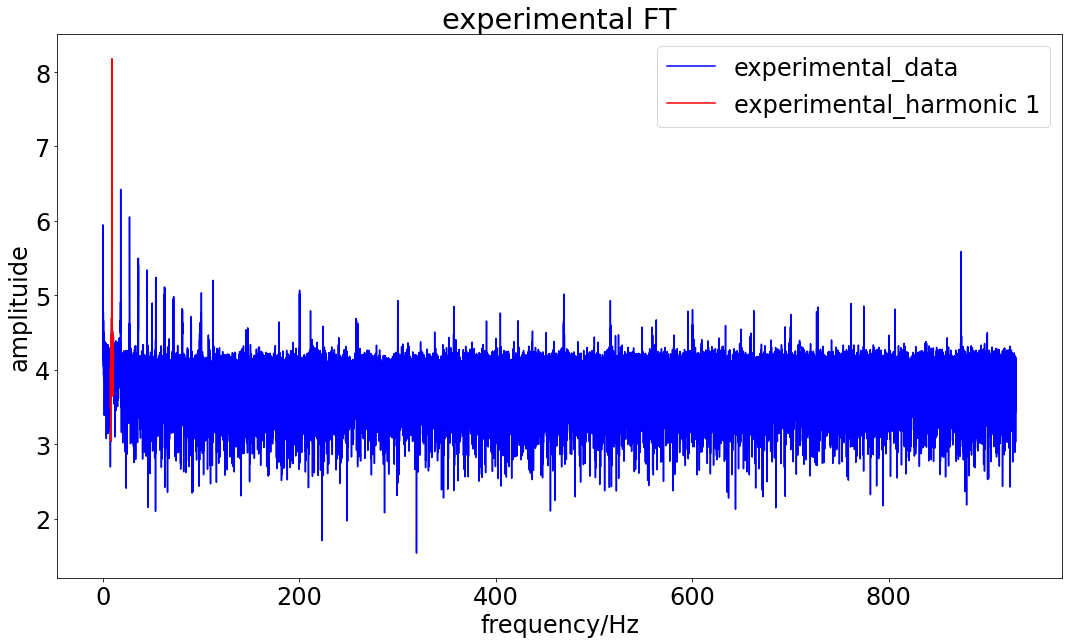

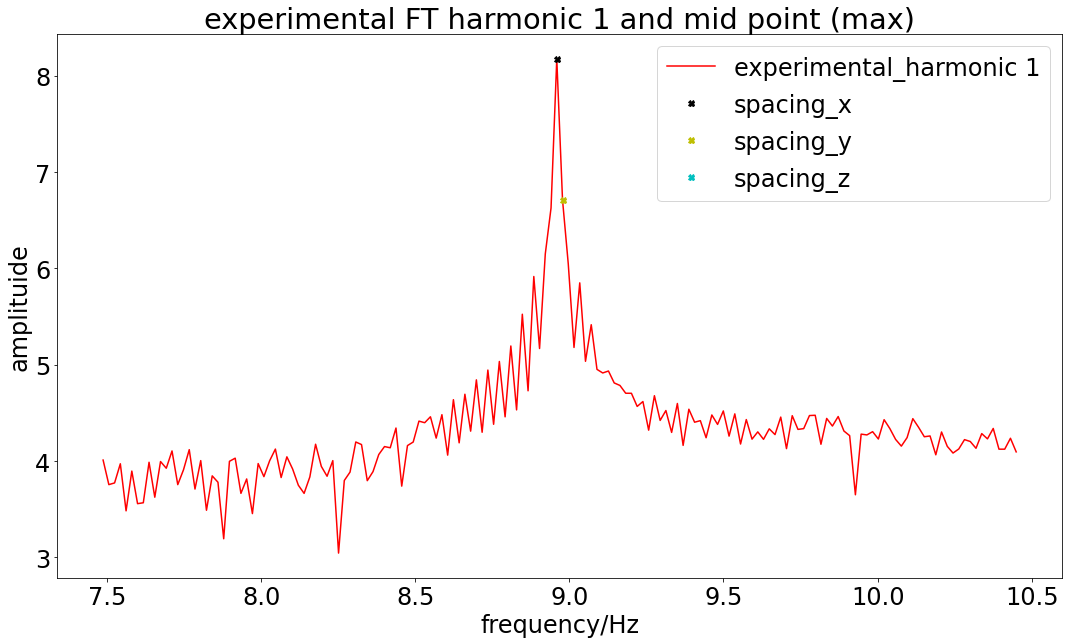

280  11529  429716.4  16:04.1
1300  11709  429716.4  16:19.2
1320  11889  429716.4  16:34.2
1340  12069  429716.4  16:49.3
1360  12249  429716.4  17:04.2
1380  12429  429716.4  17:19.2
1400  12609  429716.4  17:34.2
1420  12789  429716.4  17:49.2
1440  12969  429716.4  18:04.2
1460  13149  429716.4  18:19.1
1480  13329  429716.4  18:34.0
1500  13509  429716.4  18:49.1
1520  13689  429716.4  19:04.3
1540  13869  429716.4  19:19.1
1560  14049  429716.4  19:34.1
1561  14049  429716.4  19:34.1
Halting: No significant change for 200 iterations.
random starting points:  [ 5.62189640e+02  2.68851157e+03 -2.59752947e-01 -4.46078189e-01
  1.13494210e-01  4.04222896e+00]
         Found solution: 
 1.70255929162411501e-01  :kappa0_1
 3.99999999996609904e+03  :kappa0_2
-2.91046193248728380e-01  :epsilon0_1
-3.89320861643899285e-01  :epsilon0_2
 3.42056011579118802e-02  :mew
 1.81285306996622975e+00  :zeta
lower_bounds:  [ 0.     0.    -0.58  -0.58  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+0

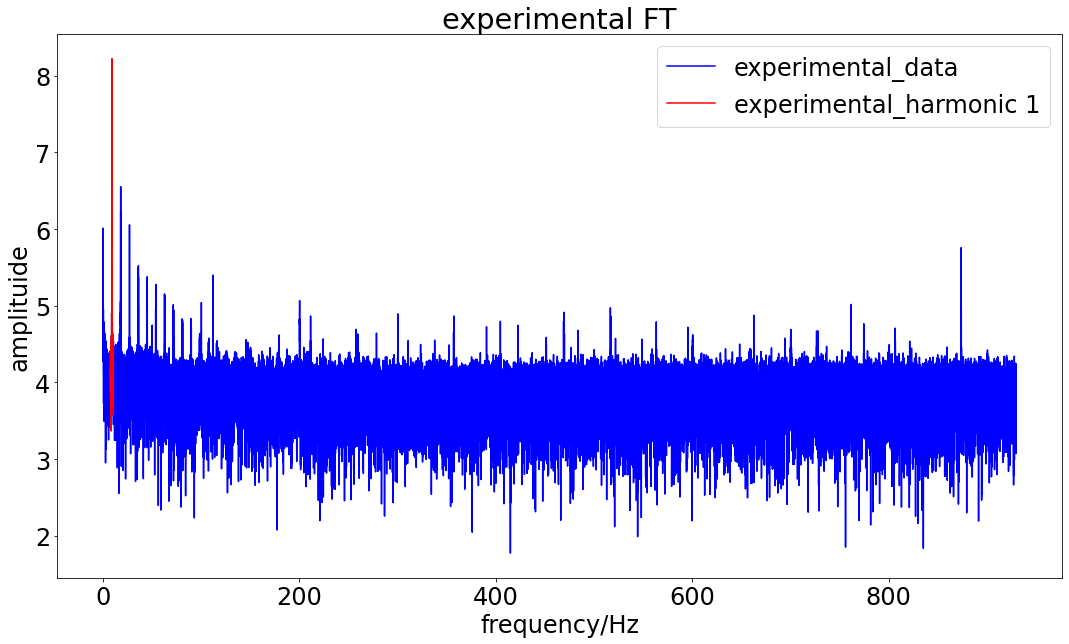

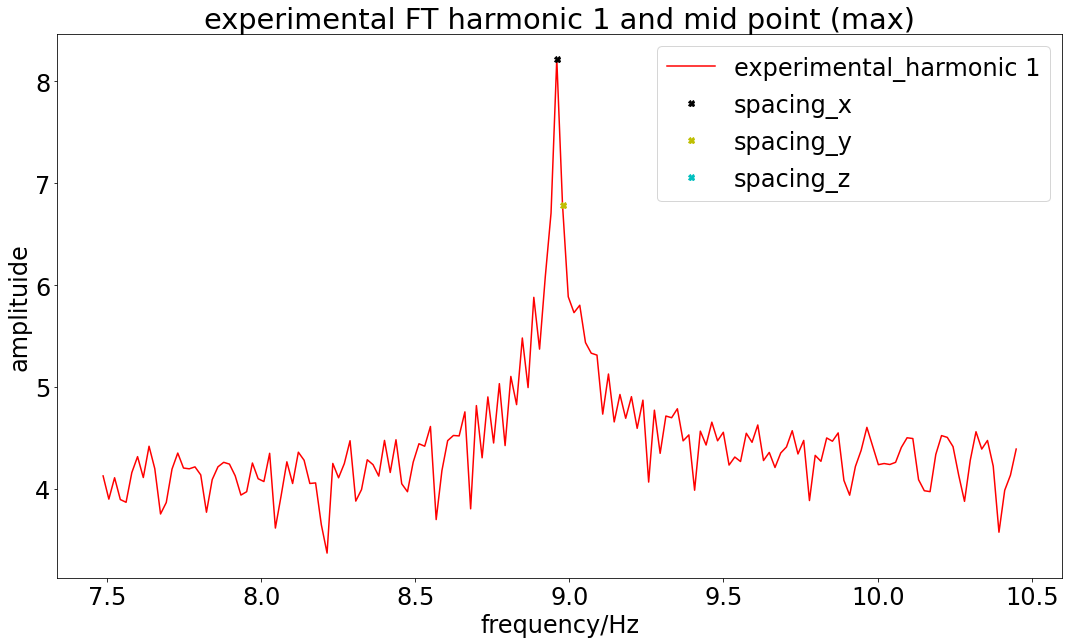

2.0
780   7029   434171.3   9:47.1
800   7209   434171.3  10:02.1
820   7389   434171.3  10:17.4
840   7569   434171.3  10:32.2
860   7749   434171.3  10:47.1
880   7929   434171.3  11:02.2
900   8109   434171.3  11:17.3
920   8289   434171.3  11:32.5
940   8469   434171.3  11:47.5
960   8649   434171.3  12:02.7
980   8829   434171.3  12:17.6
1000  9009   434171.3  12:32.8
1020  9189   434171.3  12:47.8
1040  9369   434171.3  13:03.0
1060  9549   434171.3  13:18.1
1067  9603   434171.3  13:22.5
Halting: No significant change for 200 iterations.
random starting points:  [ 1.34829805e+03  2.05940404e+03 -5.50571535e-01 -2.78053344e-01
  1.55310288e-01  7.42660432e+00]
         Found solution: 
 3.99999999978562028e+03  :kappa0_1
 3.86756184059589314e+00  :kappa0_2
-4.57083483116556666e-01  :epsilon0_1
-5.94845564067623567e-01  :epsilon0_2
 2.56833096575403985e-02  :mew
 1.88001828200250887e+00  :zeta
lower_bounds:  [ 0.     0.    -0.63  -0.63  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.

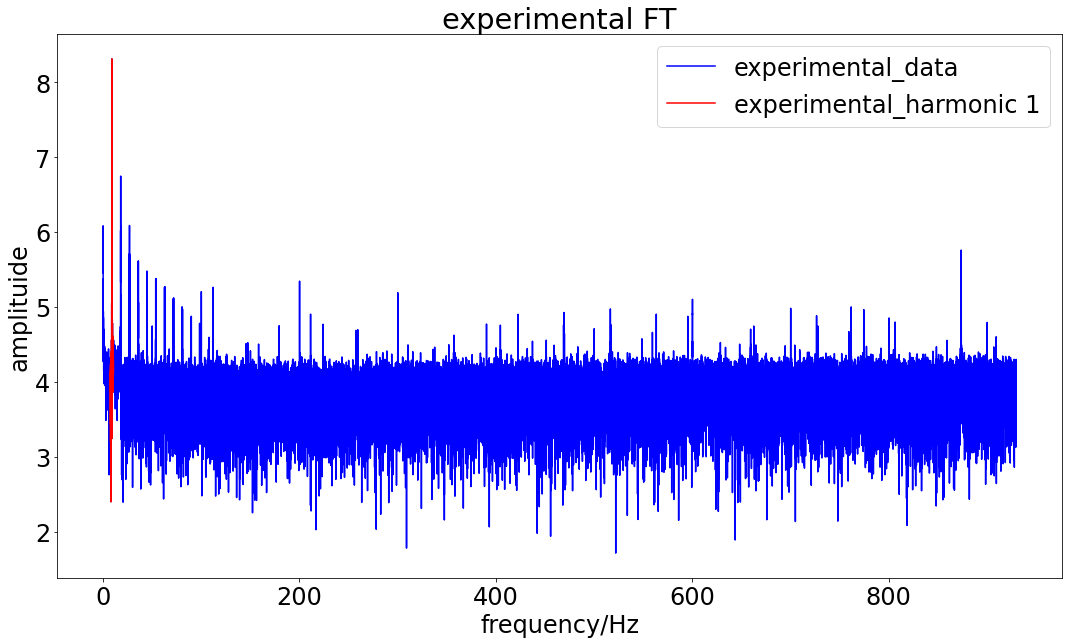

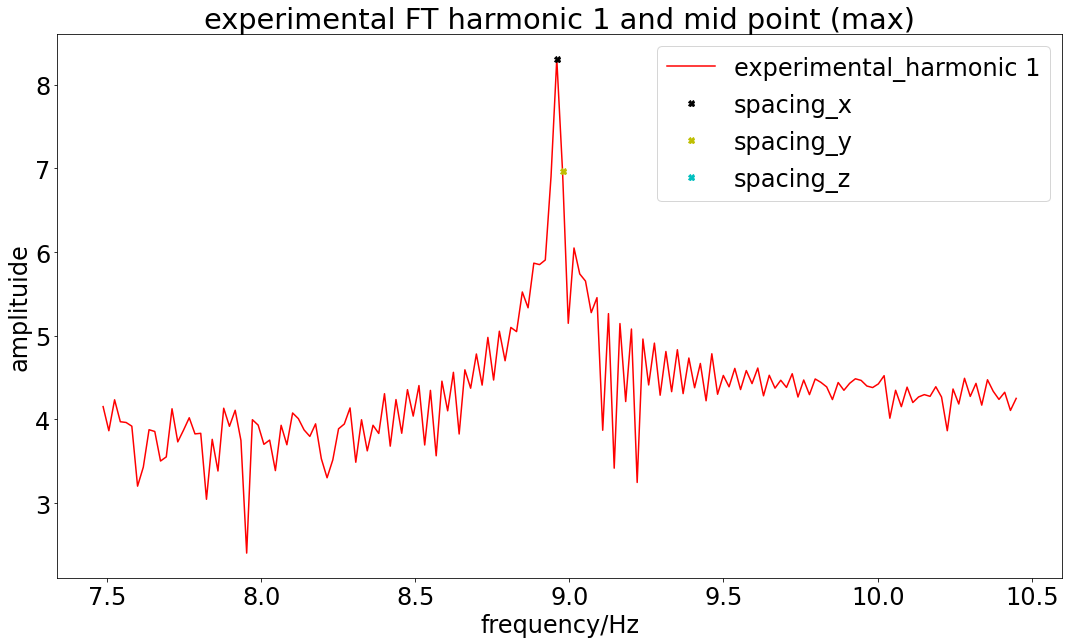

+01]
random starting points:  [ 2.43262748e+03  1.24444092e+03 -5.97675573e-01 -3.91773002e-01
  2.29681914e-01  7.52739548e-01]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      598170     0:00.9
1     18     459134     0:01.6
2     27     396461.8   0:02.4
3     36     396461.8   0:03.2
20    189    348554.4   0:16.5
40    369    344952.8   0:31.6
60    549    343372.2   0:46.7
80    729    341210.5   1:01.8
100   909    338917.2   1:17.2
120   1089   336090.4   1:32.3
140   1269   334927.2   1:47.5
160   1449   333256.2   2:02.6
180   1629   332051.5   2:17.8
200   1809   331761.7   2:33.0
220   1989   331657.7   2:48.2
240   2169   331633.9   3:03.6
260   2349   331632.3   3:18.6
280   2529   331631.9   3:33.8
300   2709   331631.8   3:48.8
320   2889   331631.8   4:03.8
340   3069   331631.8   4:19.2
360   3249   331631.8   4:34.3
380   

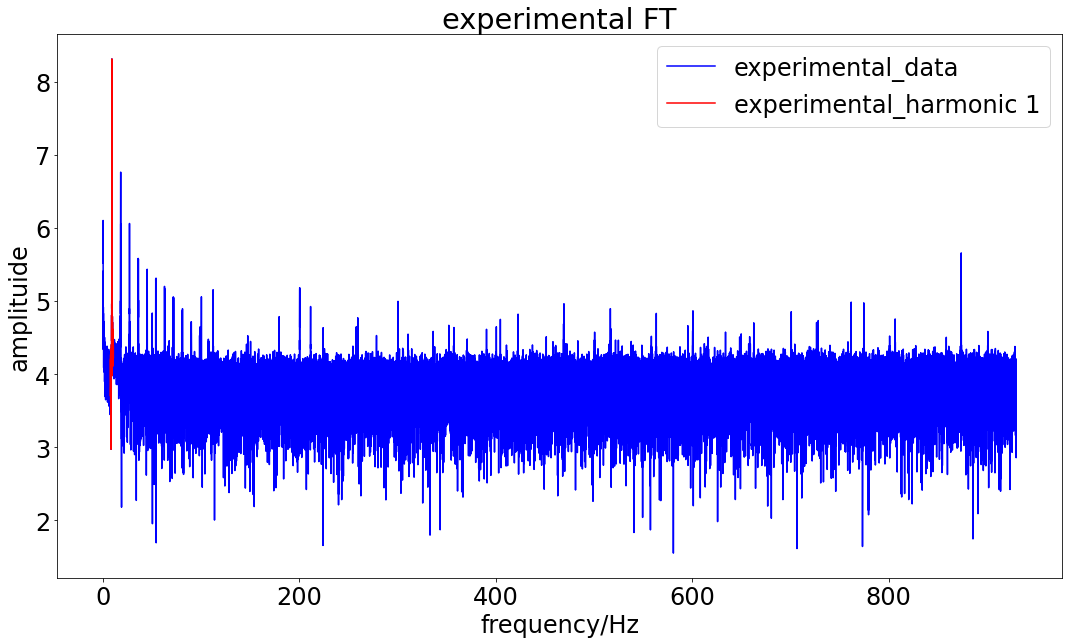

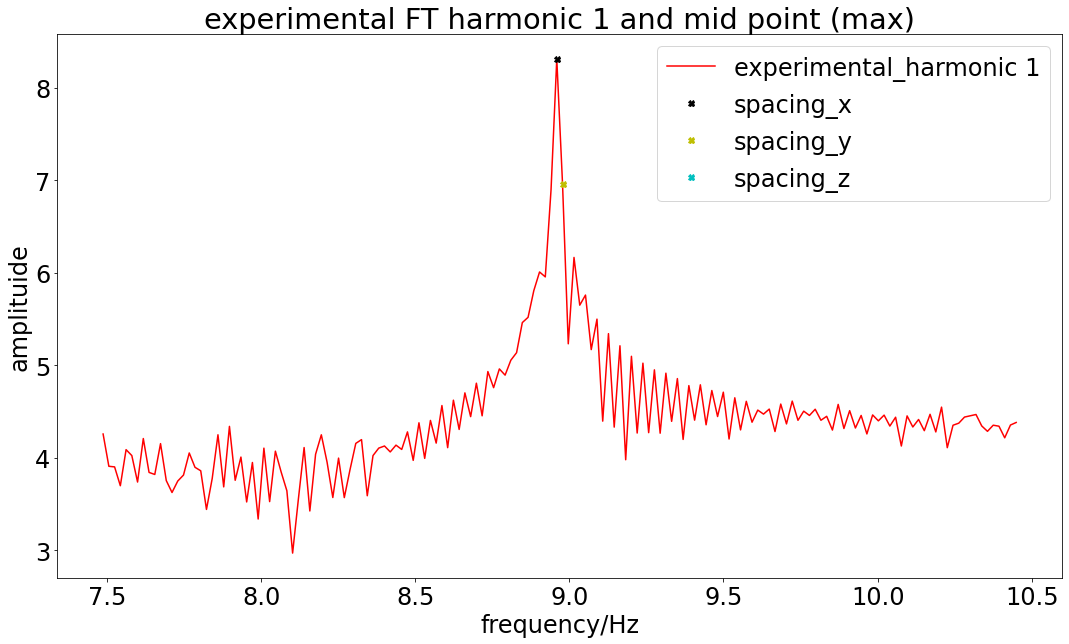

_bounds:  [ 0.     0.    -0.73  -0.73  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -3.70e-01 -3.70e-01  3.14e-01  1.00e+01]
random starting points:  [ 6.48773107e+02  1.48286608e+02 -4.33439505e-01 -5.56575826e-01
 -2.15566800e-01  1.70951131e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      1946857    0:00.9
1     18     1934011    0:01.7
2     27     1888035    0:02.5
3     36     1874862    0:03.3
20    189    1230559    0:16.0
40    369    1117956    0:31.2
60    549    576946.8   0:46.5
80    729    570011.8   1:01.8
100   909    567674     1:16.9
120   1089   567571.9   1:32.2
140   1269   567504.8   1:47.4
160   1449   567450.9   2:02.8
180   1629   567433.6   2:18.0
200   1809   567431.4   2:33.3
220   1989   567430.3   2:48.6
240   2169   567430.1   3:03.7
260   2349   567430     3:18.9
280   2529   567430     3:34.2
300 

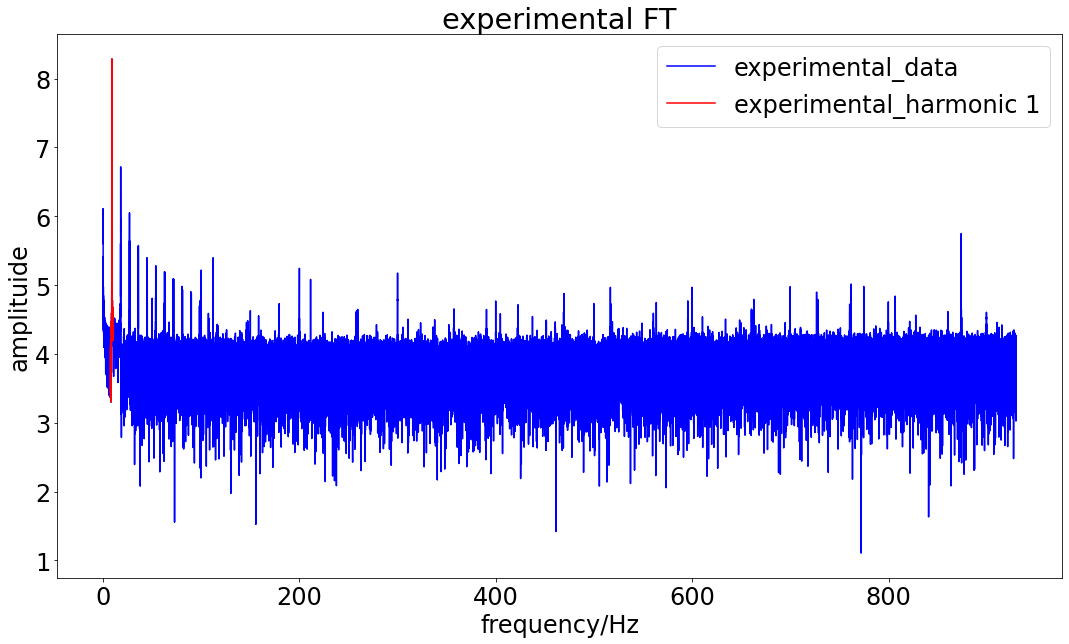

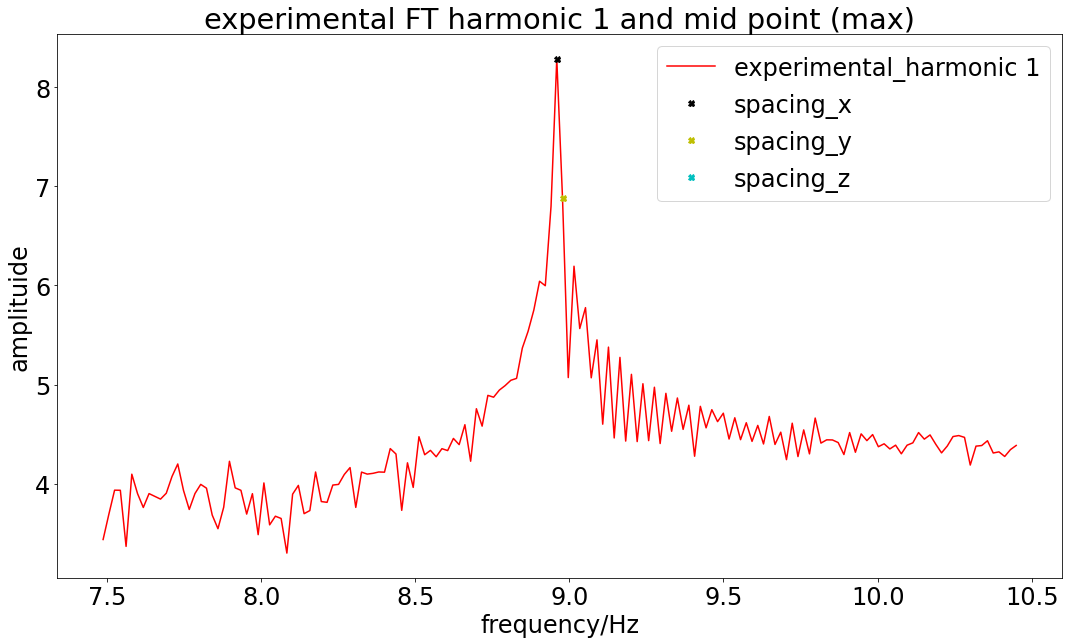

6849   545391     9:43.1
780   7029   545391     9:58.2
800   7209   545391    10:13.5
820   7389   545391    10:28.9
840   7569   545391    10:44.2
860   7749   545391    10:59.5
880   7929   545391    11:15.0
900   8109   545391    11:30.3
920   8289   545391    11:45.8
940   8469   545391    12:01.0
960   8649   545391    12:16.5
980   8829   545391    12:31.8
1000  9009   545391    12:47.1
1020  9189   545391    13:02.5
1040  9369   545391    13:17.9
1060  9549   545391    13:33.1
1080  9729   545391    13:48.6
1100  9909   545391    14:03.7
1120  10089  545391    14:18.9
1140  10269  545391    14:34.0
1160  10449  545391    14:49.2
1180  10629  545391    15:04.5
1200  10809  545391    15:20.0
1220  10989  545391    15:35.2
1240  11169  545391    15:50.3
1260  11349  545391    16:05.5
1272  11448  545391    16:14.0
Halting: No significant change for 200 iterations.
random starting points:  [ 3.68953991e+03  3.73227118e+03 -6.30563066e-01 -6.86083432e-01
 -1.03704128e-01  9.33324227

In [20]:
 %%time

for index in range(6):
    # specifing files and model 
    # specifing data location and folder for outputs

    Phfolder = ['ph4 2m nacl 25oC','ph5 2m nacl 25oC','ph6 2m nacl 25oC','ph7 2m nacl 25oC','ph8 2m nacl 25oC','ph9 2m nacl 25oC']

    data_file_names = ['9_1b_cv_current_reduced_0', '9 150_1_cv_current_reduced_0',
                       '9 150_1_cv_current_reduced_0', '9 150_1_cv_current_reduced_0',
                       '9 150_1_cv_current_reduced_0', '9 150_1_cv_current_reduced_0']

    experiment_folder = ['9_1b', '9 150_1',
                         '9 150_1', '9 150_1',
                         '9 150_1', '9 150_1']


    startPotential_list = [-50.0E-3, -100.0E-3, -150.0E-3, -200.0E-3, -250.0E-3, -300.0E-3]
    revPotential_list = [-650.0E-3, -700.0E-3, -750.0E-3, -800.0E-3, -850.0E-3, -900.0E-3]
    uncomp_resis_list = [3.25460256346968535e+01, 5.37314919777277566e+01, 7.08611591057770340e+01, 9.96182135864624883e+01, 1.21158532172995692e+02,  8.49462192172562851e+01]

    cap_params_list = [[1.86297230220671013e-04,  1.39822653956737887e-04,  3.70334718994700957e-04,  1.95151420289721824e-04,
                        1.89160174120079532e-04, 1.72641574066296957e-04,  4.39360662946530105e-04,  2.43245023587764127e-04,
                        5.62930331951245577e+01],

                        [1.94632385027365326e-04,  1.09253285539026362e-04,  2.88119332129457926e-04,  1.26365695364661712e-04,
                         2.02905525432579468e-04,  1.80802992240527245e-04,  4.31389670905371527e-04,  2.20819251598831749e-04,
                         5.62930048853382772e+01],

                        [2.04723758044318639e-04,  2.31336630663295413e-05,  6.72509298629887266e-05, -3.52788102432985851e-05,
                         2.19537056057108508e-04,  1.36486908914754557e-04,  2.84492284788390691e-04,  9.96760202484289499e-05,
                         5.62930284827410787e+01],

                        [2.31095695830451942e-04, -3.33934177299140787e-05,  2.61216901020460811e-05, -4.37104150789705166e-05,
                         2.48585906227519031e-04,  8.43383713125692245e-05,  2.31490410247125328e-04,  7.27244520034868620e-05,
                         5.62930708123702175e+01],

                        [2.10391115806213128e-04, -1.67952542029820950e-04, -2.27521009171846394e-04, -1.82193833250398891e-04,
                         2.37152205646129651e-04, -1.71347100881736204e-05,  1.08693102028162812e-05, -5.80861431062988914e-05,
                         5.62930710973902677e+01],
                        
                        [1.66897436397565733e-04, -3.31979789530825959e-04, -5.19142835131111398e-04, -3.20477732818692882e-04,
                         2.13029462149344804e-04, -9.50965617253446503e-05, -1.66949197483975248e-04, -1.49813481199269610e-04,
                         5.62930818562991533e+01]
                        ]
    
    initalDiscard_list = [0.035, 0.035, 0.035, 0.035, 0.035, 0.035]
    endDiscard_lst = [0.880, 0.880, 0.880, 0.880, 0.880, 0.880]
    # know paramteres for 9 150_1_cv_current_reduced_2
    freq_list= np.asarray([8.977950e+00, 8.977950e+00 , 8.977950e+00, 8.977950e+00, 8.977950e+00, 8.977950e+00])
    rateOfPotentialChange = -22.35174e-3

    deltaepislon = 150.0E-3
    electrode_area = 0.03
    electode_coverage = 6.5e-12


    Hz_interval_fitting_interval = freq_list*0.05

    adjustment = [-1, -1, -1, -1, -1, -1]
    fourthAdjustment = [-4, -4, -4, -4, -4, -4]

    data_name = data_file_names[index]
    file_name = data_name + '.txt'
    folder = os.path.join('Data', 'processed')
    folder = os.path.join(folder, '220415')
    folder = os.path.join(folder, Phfolder[index])
    folder = os.path.join(folder, 'ac')
    folder = os.path.join(folder, experiment_folder[index])
    data_file = os.path.join(folder, 'experimental')
    data_file = os.path.join(data_file, file_name)

    # creating file for output
    fitting_technique = 'harmonic '
    output_file_name = fitting_technique + 'fitting_for_faradaic_data'
    output_file_name = output_file_name + '.txt'
    folder = os.path.join(folder, 'faradaic_fitting')
    folder = os.path.join(folder, 'harmonics4-12')
    f= open(os.path.join( folder, output_file_name),"w")

    # opening data
    experimental_data = pd.read_csv(data_file, sep='\t')

    exp_times = np.asarray(experimental_data.time)
    exp_current = np.asarray(experimental_data.current)

    # know paramteres that are data specific
    inital_current = exp_current[index]
    startPotential= startPotential_list[index]
    revPotential = revPotential_list[index]
    uncomp_resis = uncomp_resis_list[index]

    # delacring capactiance parameters
    # (gamma0, gamma1, gamma2, gamma3, omega)
    cap_params = cap_params_list[index][:]

    measurements = exp_current.shape[0]
    # print('measurements: ', measurements)
    # if measurements%2 !=0:
    #     print('*'*30+'\nerror must have evennumber of measurments\n'+'*'*40)

    # declaring model to obtain non dimensinalise constant
    trial = newtonRaphsonFT(timeStepSize=exp_times[1], inital_current=inital_current, freq=freq_list[index], startPotential= startPotential, revPotential = revPotential,
                            rateOfPotentialChange = rateOfPotentialChange, numberOfMeasurements = measurements, deltaepislon=deltaepislon,
                            uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage)

    # non-diming experimental data
    exp_current_dimless = exp_current/trial.I0

    # model for optimsation
    model = wrappedNewton(times = exp_times, inital_current=inital_current, freq=freq_list[index], startPotential= startPotential,
                            revPotential = revPotential, rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon,
                            uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage,
                            initaldiscard = initalDiscard_list[index], enddiscard = endDiscard_lst[index], cap_params=cap_params)

    real_parameters = model.suggested_parameter()
    parameter_order = ['kappa0_1', 'kappa0_2', 'epsilon0_1', 'epsilon0_2', 'mew', 'zeta']
    real_parameters = np.asarray(real_parameters)
    real_parameters = np.asarray([4.00000000000000000e+03, 4.00000000000000000e+03, -5.03044038352866596e-01, -5.03044038352866596e-01, -1.69999999999999984e-01, 4.90950349026095523e-01])
    f.write("experimental data: " + data_file + "\r\n")
    print('experimental data: ',data_file)

    # checking loaction of harmonics 1-4
    half_of_measuremnts = int(measurements/2)

    # full FT and frequencies
    full_sim = np.fft.fft(exp_current_dimless)
    half_full_sim = full_sim[:half_of_measuremnts]

    freq_org = np.fft.fftfreq(exp_times.shape[-1], d= exp_times[1])
    freq_org=freq_org[:half_of_measuremnts]

    # regional FT and Frequency

    freq = model.frequencies_for_harmonics_4_to_12(exp_times)

    harmonics1To4 = model.FT_and_reduce_to_harmonics_4_to_12(exp_current_dimless)

    xaxislabel = "frequency/Hz" # "potential/V"
    plt.figure(figsize=(18,10))
    plt.title("experimental FT")
    plt.ylabel("amplituide")
    plt.xlabel(xaxislabel)
    plt.plot(freq_org, np.log10(half_full_sim),'b', label='experimental_data')
    plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
    plt.legend(loc='best')
    plt.savefig(os.path.join( folder, 'experiment FT data and range 4-12.pdf'))
    plt.close()

    xaxislabel = "frequency/Hz" # "potential/V"
    plt.figure(figsize=(18,10))
    plt.title("experimental harmonics 1 -4 ")
    plt.ylabel("amplituide")
    plt.xlabel(xaxislabel)
    plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
    plt.legend(loc='best')
    plt.savefig(os.path.join( folder, 'experiment FT harmonics 4-12.pdf'))
    plt.close()

    # declaring problem

    problem = pints.SingleOutputProblem(model, exp_times, exp_current_dimless)

    score = ComplexRootMeanSquaredError_harmonics(problem, model, Hz_interval=Hz_interval_fitting_interval[index], times=exp_times, adjustment = adjustment[index], fourthAdjustment = fourthAdjustment[index])

    e_min = model.startPotential + 0.2*(model.revPotential - model.startPotential)
    e_max = model.startPotential + 0.8*(model.revPotential - model.startPotential)

    lower_bounds = np.asarray([0.0, 0.0, e_max, e_max, -0.314, 0.0])#, 0.1])
    upper_bounds = np.asarray([4000.0, 4000.0, e_min, e_min, 0.314, 10])#, 4.5])

    boundaries = pints.RectangularBoundaries(lower_bounds, upper_bounds)

    # optimisimg
    total_runs = 10
    dims = real_parameters.shape
    print('dims: ', dims)
    print('dims[0]: ', dims[0])
    params_matrix = np.zeros((total_runs, dims[0]))
    for run in range(total_runs):
            
        if run > 0:
            f = open(os.path.join( folder, output_file_name),"a")

        f.write("\r\n\r\n" + 40*"*" + " Run: %d " % run + 40*"*" + "\r\n\r\n")
        print('\n\n' + 40*"*" + ' Run: ', run, ' ' + 40*"*" + '\n\n')
        accuracy = (2 + run)
        # f.write("Threshold for stopping: %e\r\n\r\n" % pow(10,-accuracy))
        # print('Threshold for stopping: ', pow(10,-accuracy))

        ranges = upper_bounds - lower_bounds 

        starting_points = np.copy(lower_bounds)
        for i in range(len(ranges)):
            starting_points[i] += ranges[i] * np.random.uniform(low = 0.001, high = 0.999)
        
        print('lower_bounds: ', lower_bounds)
        print('upper_bounds: ', upper_bounds)

        print('random starting points: ', starting_points)

        f.write("lower_bounds: ")
        for i in lower_bounds:
            f.write("%e, " % i)
        f.write("\r\nupper_bounds: ")
        for i in upper_bounds:
            f.write("%e, " % i)
        f.write("\r\nRandom starting_points: ")
        for i in starting_points:
            f.write("%e, " % i)
        f.write("\r\n")

        # transformation
        transform = pints.RectangularBoundariesTransformation(boundaries)

        # optimising boundaries=boundaries,
        opt = pints.OptimisationController(
            score,
            x0=starting_points,
            method=pints.CMAES,
            transform = transform)

            
        #opt.set_max_unchanged_iterations(iterations=50, threshold=pow(10,-accuracy))
        #opt.set_max_unchanged_iterations(iterations=100)
        opt.set_parallel(parallel=True)
        #opt.set_max_iterations(iterations=1)
        opt.set_log_interval(iters=20, warm_up=3)
        #opt.set_threshold(threshold=-??????)
        
        found_parameters, found_value =  opt.run()
            #CMAES, PSO, SNES, XNES
        # output results

        print('random starting points: ', starting_points)

        f.write("Found solution: ")
        for k, x in enumerate(found_parameters):
            f.write(pints.strfloat(x) +", ")

        print('         Found solution: ')
        name = 0
        for k, x in enumerate(found_parameters):
            print( pints.strfloat(x) +'  :' + parameter_order[name])
            name = name + 1

        print('lower_bounds: ', lower_bounds)
        print('upper_bounds: ', upper_bounds)

        f.write("\r\n\r\nFound solution:\r\n")
        name = 0
        for k, x in enumerate(found_parameters):
            f.write(pints.strfloat(x) + '  :' + parameter_order[name]+ '\r\n')
            name = name + 1

        params_matrix[run, :] = found_parameters

        # plotting current for found parameters over the experimentally data

        xaxis = exp_times #model.potentialRange
        xaxislabel = "time/s" # "potential/V"
        solution = model.simulate(found_parameters, exp_times)


        plt.figure(figsize=(18,10))
        plt.title("optimised and experimental values")
        plt.ylabel("Fourier transformed current/dimless")
        plt.xlabel(xaxislabel)
        plt.plot(xaxis, exp_current_dimless,'r', label='experiment')
        plt.plot(xaxis ,solution,'b', label='optimised_'+str(found_parameters[0])+'_'+str(found_parameters[1]))
        plt.legend(loc='best')
        plt.savefig(os.path.join( folder, 'experiment against optimised with potential run '+str(run)+'.pdf'))
        #plt.show()
        plt.close()
        
        found_score = score(found_parameters)
        print("Score at found solution:", found_score)
        f.write("Score at found solution: %.16e\r\n" % found_score)

        run += run
    f.close()